In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
import calendar
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist


from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


rcParams['figure.figsize'] = 16,4
df = pd.read_csv('database.csv', low_memory=False)
df = pd.read_csv('database.csv', low_memory=False)
df.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [9]:
states = df[['Year', 'Month', 'State', 'Incident']]
states = states.groupby(['Year', 'Month', 'State'], as_index=False)['Incident'].sum()

states['Date'] = states.apply(lambda row: '{}-{}'.format(row.Year, row.Month), axis=1)
states.reset_index()
states.Date = pd.to_datetime(states.Date, format='%Y-%B')
states = states[['State', 'Incident', 'Date']]

states.Date = pd.to_datetime(states.Date, format='%Y-%B')
states.reset_index()
states.head()

,State,Incident,Date
0,Alabama,72,1980-04-01
1,Alaska,4,1980-04-01
2,Arizona,106,1980-04-01
3,Arkansas,55,1980-04-01
4,California,3743,1980-04-01


In [10]:
states_total = df[['State', 'Incident']]
states_total = states_total.groupby(['State'],as_index=False).sum()
states_total.columns = ['State', 'Incident']
states_total = states_total.sort_values(['Incident'], ascending=[True])
states_list = list(states_total.State)
states_list[:5]

['North Dakota', 'Vermont', 'South Dakota', 'Montana', 'Wyoming']

In [12]:
idx = pd.date_range(datetime(1980, 1, 1), datetime(2014, 12, 31), freq=pd.tseries.offsets.DateOffset(months=1))

my_series = pd.DataFrame()
s = pd.pivot_table(states,index=["State", "Date"], values=["Incident"], aggfunc=[np.sum])

for i in range(0,51):
    state = states_list[i]
    x = s.query('State == ["{}"]'.format(state))
    x = x.reset_index()
    x = x.set_index(pd.DatetimeIndex(x['Date']))
    x = x[['sum']]
    x.columns = ['Incident']
    x = x.reindex(idx, fill_value=0)
    x = x.fillna(0)
    my_series[state] = pd.Series(x['Incident'].values)
    
# my_series = my_series[:50]
my_series.T.head()

,0,1,2,3,4,5,6,7,8,9,...,410,411,412,413,414,415,416,417,418,419
North Dakota,2,2,2,0,3,0,0,0,0,0,...,3,0,0,2,0,1,1,1,2,1
Vermont,1,1,0,0,0,0,0,1,0,3,...,0,2,1,0,1,1,0,0,2,0
South Dakota,0,1,0,0,2,0,0,0,1,0,...,2,1,1,1,1,2,4,0,8,1
Montana,1,1,0,4,2,1,6,2,9,4,...,4,3,1,1,8,2,2,2,1,3
Wyoming,1,3,3,2,1,2,6,5,6,5,...,0,0,0,2,1,1,3,1,1,3


In [13]:
y = my_series['Illinois']
y2 = my_series['California']

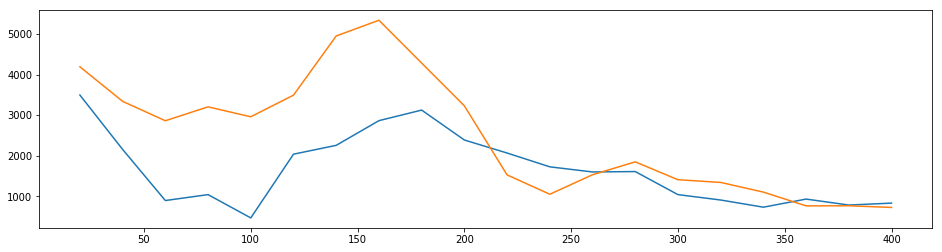

In [14]:
import pandas as pd
winsmooth = 20
ysmooth = y.rolling(window=winsmooth).mean()
ysmooth2 = y2.rolling(window=winsmooth).mean()
#plot(ysmooth)
samples = [winsmooth*i for i in range(len(ysmooth) // winsmooth)]
samples2 = [winsmooth*i for i in range(len(ysmooth2) // winsmooth)]
plt.plot(samples,ysmooth[samples])
plt.plot(samples2,ysmooth2[samples2])
plt.show()

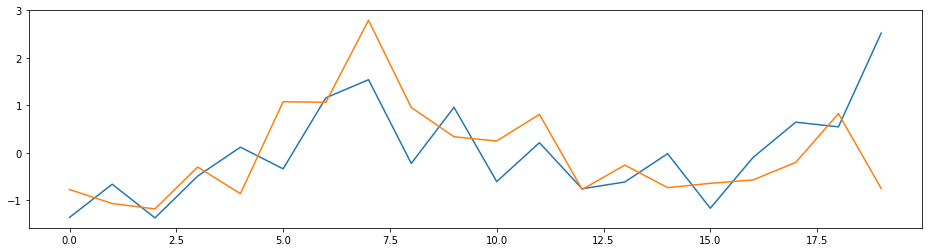

2.22044604925e-17 8.32667268469e-17 1.0 1.0


In [15]:
offset = 0
win = 20
ys = y[offset:(offset+win)]
ys2 = y2[offset:(offset+win)]
# Normalize
ys = (ys - ys.mean()) / ys.std()
ys2 = (ys2 - ys2.mean()) / ys2.std()
plt.plot(ys)
plt.plot(ys2)
plt.show()
print(ys.mean(), ys2.mean(), ys.std(), ys2.std())

In [17]:
def distance(x,y):
    return abs(x-y)

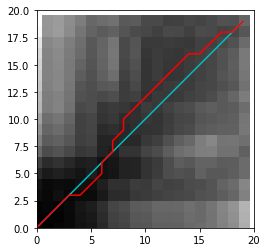

0.27946127892468586

In [20]:
from dtw import dtw
d, aa, cc, ll = dtw(ys,ys2,distance)
plt.imshow(cc.T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.plot(ll[0], ll[0], 'c-')
plt.plot(ll[0], ll[1], 'r')
plt.xlim(0,len(ys))
plt.ylim(0,len(ys2))
plt.show()
d

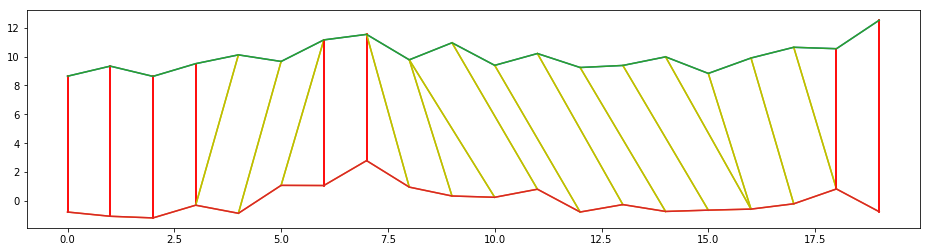

In [23]:
yshift = 10
for i in range(len(ll[0])):
    if ll[0][i] == ll[1][i]:
        col = 'r-'
    else:
        col = 'y-'
    plt.plot([ ll[1][i], ll[0][i] ] , [ ys2[ll[1][i]], ys[ll[0][i]]+yshift ], col)
plt.plot(ys+yshift)
plt.plot(ys2)
plt.show()

In [24]:
dtw??

In [34]:
from numpy import inf
def dtw_band(x, y, dist, band=inf):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = np.zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j]) if abs(i-j)<band else inf
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    if len(x)==1:
        path = np.zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), np.zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1, path

def _traceback(D):
    i, j = np.array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = np.argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return np.array(p), np.array(q)

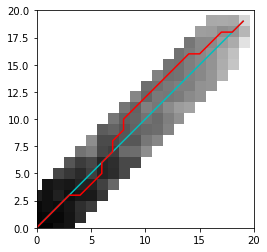

0.27946127892468586

In [53]:
d, aa, cc, ll = dtw_band(ys,ys2,distance,band=4)
plt.imshow(cc.T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.plot(ll[0], ll[0], 'c-')
plt.plot(ll[0], ll[1], 'r')
plt.xlim(0,len(ys))
plt.ylim(0,len(ys2))
plt.show()
d

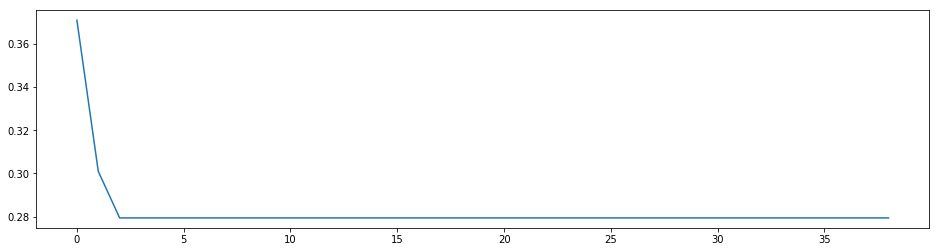

In [54]:
d_list = [ dtw_band(ys,ys2,distance,band=b)[0] for b in range(1,40) ]
plt.plot(d_list)
plt.show()

In [40]:
def dtw_parallel(x, y, dist, coeff=inf):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = np.zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j]) if abs(j-i) < (min(i,j,r-i,c-j)+1)*coeff else inf
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    if len(x)==1:
        path = np.zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), np.zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1, path

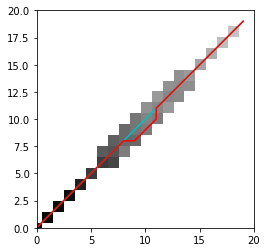

0.35857623309984088

In [51]:
d, aa, cc, ll = dtw_parallel(ys,ys2,distance, coeff=0.15)
plt.imshow(cc.T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.plot(ll[0], ll[0], 'c-')
plt.plot(ll[0], ll[1], 'r')
plt.xlim(0,len(ys))
plt.ylim(0,len(ys2))
plt.show()
d

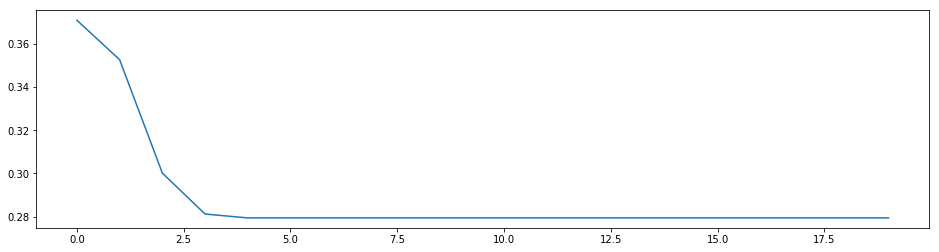

In [50]:
d_list = [ dtw_parallel(ys,ys2,distance,coeff=c)[0] for c in np.linspace(0.1,2.0,20) ]
plt.plot(d_list)
plt.show()